# Customer Segmentation

## Introduction

In this notebook we'll do some customer segmentation work. Segmentation can help you to identify and understand customer subgroups and how they differ from one another. Customer segmentation has many beneficial uses. In our case for example, it can be used to assign the best-fit agent, identify opportunities for leveraging agent skills, or even to create hosting opportunities to improve client engagement.<br><br>
We'll prepare the data so it's in a wide format ready for segmentation and then apply some transformation and clustering techniques. Our data contains demographic, summary product, and communication information. Since there are currently no predefined segments we'll need to discover segments within the underlying data structure. Once that structure is found we'll assign clients to their respective clusters and surface that information through and user interface.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In [18]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys
import joblib

if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')
    
from customer_segmentation_prep import *

%matplotlib inline

## Plot Functions

Here is a plotting function with an example to view the distribution of any feature within the dataset

In [3]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


This function plots the distribution of categorical variables by each cluster

In [4]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform):
    df_temp = prepped_data_pre_transform.groupby(['CLUSTERS', cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index='CLUSTERS', columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index('CLUSTERS').plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return

This function plots the distribution of numerical variables by each cluster

In [5]:
def plot_numeric_vars(var, prepped_data_pre_transform):
    
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in range(0, 7):
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS'] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## User Inputs and Data Prep

### User Inputs
**effective_date :**  This is the date that the segmentation is computed. All input data should be before this date.<br>
**train_or_score :**  Specify whether we are prepping the data for training or scoring. Should always be 'train' in this notebook.<br>

**granularity_key :** Specifies the customer ID column.<br>
**customer_start_date :** Column with the start of the summary month of customer data.<br> 
**customer_end_date :** As above, but last day of the summary month.<br>
**status_attribute :** Column which indicates whether the customer is active or inactive and is used to define churn. Churned customers are removed from the dataset.<br>
**status_flag_active :** The name of the variable in the status_attribute that indicates that the customer has churned, in this case it is 'Inactive'.<br>
**date_customer_joined :** Specifies the column where the customer join date is recorded. This variable is used to calculate customer tenure.<br>

**columns_required :** A list of default columns required, includes ID column and date columns.<br>
**default_attributes :** A list of the variables that we would like to use for the segmentation.<br>
**risk_tolerance_list :** A list of the risk categories for the customer's accounts. 'High', 'Low' etc.<br> 
**investment_objective_list :** A list of the investment objective categories for the customer's accounts. 'Security', 'Income' etc.<br>

The last three user input variables are used for data cleaning.<br>
**std_multiplier :** This variable is used to identify outlier values. This number is multiplied by the variable standard deviation. Any value above this is defined as an outlier and the value is capped at this number multiplied by the standard deviation.<br>
**max_num_cat_cardinality :** This variable defines the maximum cardinality for categorical variables. Any categorical variable with more categories than this maximum is removed from the dataset.<br> 
**nulls_threshold :** This threshold is used to identify columns with many null values. Any column with percentage of nulls greater than this threshold will be removed from the dataset.<br>

The user can use the default inputs as listed below or can choose their own. The user inputs will be stored and the same inputs will be applied automatically at scoring time. 


### Data Prep
See scripts/customer_segmentation_prep.py for details of data preparation.

The script generates the dataset that is used for clustering. We take a wide form dataset with customer details, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for clustering. 

### Data Cleaning
•	Any customer who churned in the dataset is removed. Only active customers are used for clustering.<br>
•	We take the most recent record for each customer.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 10% null values is removed.<br>
•	High cardinality categorical columns are removed.<br>
•	Numerical outliers are cleaned. <br>
•	Remaining missing values are filled with 'Unknown' for categorical and the average of the column for numerical. 

In [6]:
# User input variables
effective_date = '2018-09-30'  # date at which the prediction was computed 
train_or_score = 'train'

granularity_key='CUSTOMER_CUSTOMER_ID'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
status_attribute='CUSTOMER_STATUS'
status_flag_active='Active'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'

columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                    'CUSTOMER_EFFECTIVE_DATE',  'CUSTOMER_SYSTEM_LOAD_TIMESTAMP']

default_attributes=['CUSTOMER_GENDER', 'CUSTOMER_AGE_RANGE', 'CUSTOMER_EDUCATION_LEVEL',
                            'CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_MARITAL_STATUS', 
                            'CUSTOMER_URBAN_CODE', 'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_RELATIONSHIP_START_DATE', 
                            'CUSTOMER_SUMMARY_RETURN_LAST_QUARTER', 'CUSTOMER_SUMMARY_ASSETS',
                            'CUSTOMER_SUMMARY_NUMBER_OF_EMAILS',
                            'CUSTOMER_SUMMARY_NUMBER_OF_LOGINS', 'CUSTOMER_SUMMARY_NUMBER_OF_CALLS',
                    'CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES',
                           'CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY', 'CUSTOMER_CREDIT_AUTHORITY_LEVEL', 'CUSTOMER_CUSTOMER_BEHAVIOR', 'CUSTOMER_IMPORTANCE_LEVEL_CODE',
                           'CUSTOMER_MARKET_GROUP',
                           'CUSTOMER_PURSUIT']
risk_tolerance_list = []
investment_objective_list = []

std_multiplier=5
max_num_cat_cardinality=15
nulls_threshold=0.1

In [7]:
df_raw = pd.read_csv('../datasets/customer_full_summary_latest.csv',
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE',
                                 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE'], infer_datetime_format=True)

data_prep = CustomerSegmentationPrep(train_or_score=train_or_score, effective_date=effective_date, granularity_key=granularity_key, customer_start_date=customer_start_date, customer_end_date=customer_end_date,
                                        status_attribute=status_attribute, status_flag_active=status_flag_active, date_customer_joined=date_customer_joined, columns_required=columns_required, default_attributes=default_attributes,
                                        risk_tolerance_list=risk_tolerance_list, investment_objective_list=investment_objective_list, std_multiplier=std_multiplier, max_num_cat_cardinality=max_num_cat_cardinality, nulls_threshold=nulls_threshold)
df_prepped = data_prep.prep_data(df_raw, train_or_score)

Before removing inactive customers we have 1000 customers
After removing inactive customers we have 838 customers
Before cleaning, we had 24 columns.
After cleaning, we have 20 columns.
Add a column for customer tenure
Prepped data has 838 rows and 18 columns.
Prep has data for 838 customers


In [8]:
# Preview prepped data
df_prepped.head()

CUSTOMER_CUSTOMER_ID CUSTOMER_EMPLOYMENT_STATUS  \
0                  1000                   Employed   
1                  1001               Selfemployed   
2                  1002                  Homemaker   
3                  1003                  Homemaker   
4                  1004                   Employed   

   CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES     CUSTOMER_PURSUIT  \
0                                  905.782674  Capital Acquisition   
1                                 4708.231946  Retirement Planning   
2                                  847.381644   Increase Net Worth   
3                                 1502.860545   Increase Net Worth   
4                                  433.644930      Estate Planning   

  CUSTOMER_CUSTOMER_BEHAVIOR CUSTOMER_GENDER CUSTOMER_EFFECTIVE_DATE  \
0                   Moderate            Male              2018-01-02   
1                 Aggressive          Female              2017-11-29   
2                     Growth          Female              2017-08-28   
3                     Growth          Female              2018-01-17   
4                   Moderate            Male              2018-01-03   

  CUSTOMER_MARKET_GROUP CUSTOMER_AGE_RANGE  \
0          Accumulating           30 to 40   
1               Gifting        65 and over   
2          Accumulating           55 to 65   
3          Accumulating        65 and over   
4          Accumulating           40 to 55   

  CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY CUSTOMER_URBAN_CODE  \
0                             Recreation                City   
1                          Uncategorized               Urban   
2                          Transportaion               Urban   
3                          Transportaion               Urban   
4                                   Food                City   

  CUSTOMER_MARITAL_STATUS CUSTOMER_CREDIT_AUTHORITY_LEVEL  \
0                 Married                          Medium   
1                Divorced                       Very High   
2                 Married                        Very Low   
3                 Married                        Very Low   
4                 Married                          Medium   

  CUSTOMER_IMPORTANCE_LEVEL_CODE  CUSTOMER_ANNUAL_INCOME  \
0                   Low priority                 88936.0   
1                Normal priority                144189.0   
2                  High priority                127032.0   
3                  High priority                118908.0   
4                   Low priority                 83259.0   

  CUSTOMER_EDUCATION_LEVEL  CUSTOMER_SUMMARY_ASSETS  CUSTOMER_TENURE_IN_MONTHS  
0                  College                 120823.0                          8  
1             Professional                 253441.0                         10  
2                      PhD                 203284.0                         13  
3                      PhD                 194884.0                          8  
4                  College                 123576.0                          8

Now that the data is prepared we need to continue with a few more data preparation steps before we can do clustering. First is to simply remove the columns `CUSTOMER_CUSTOMER_ID` and `CUSTOMER_EFFECTIVE_DATE` since they're not needed for segmentation.

In [9]:
# Drop columns not needed for segmentation
df_prepped.drop(['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_EFFECTIVE_DATE'], axis=1, inplace=True)

### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original categorical features.

In [10]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)

# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre_transform = df_prepped.copy()

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Standardize Data

The last step for our data preparation is to standardize the numeric variables. Standardizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [11]:
# Calculate mean and standard deviation for standardization
numeric_cols_to_exclude_from_clustering = []
dict_col_means = {}
dict_col_stds = {}
for col in numeric_cols:
    col_mean = df_prepped[col].mean()
    col_std = df_prepped[col].std()
    dict_col_means[col] = col_mean
    dict_col_stds[col] = col_std
    numeric_cols_to_exclude_from_clustering.append(col)
    
    df_prepped[col + '_standardised'] = (df_prepped[col] - col_mean)/col_std

# store the means and standard deviations in one dictionary
dict_standardise = {'mean':dict_col_means, 'std':dict_col_stds}

# drop the numeric columns from clustering data set
df_prepped.drop(numeric_cols_to_exclude_from_clustering, axis=1, inplace=True)

In [14]:
# Preview prepped data with atandardized numeric values
df_prepped.head()

CUSTOMER_EMPLOYMENT_STATUS_Homemaker  CUSTOMER_EMPLOYMENT_STATUS_Retired  \
0                                     0                                   0   
1                                     0                                   0   
2                                     1                                   0   
3                                     1                                   0   
4                                     0                                   0   

   CUSTOMER_EMPLOYMENT_STATUS_Selfemployed  \
0                                        0   
1                                        1   
2                                        0   
3                                        0   
4                                        0   

   CUSTOMER_EMPLOYMENT_STATUS_Unemployed  CUSTOMER_PURSUIT_Education Planning  \
0                                      0                                    0   
1                                      0                                    0   
2                                      0                                    0   
3                                      0                                    0   
4                                      0                                    0   

   CUSTOMER_PURSUIT_Estate Planning  CUSTOMER_PURSUIT_Increase Net Worth  \
0                                 0                                    0   
1                                 0                                    0   
2                                 0                                    1   
3                                 0                                    1   
4                                 1                                    0   

   CUSTOMER_PURSUIT_Philanthropy  CUSTOMER_PURSUIT_Retirement Planning  \
0                              0                                     0   
1                              0                                     1   
2                              0                                     0   
3                              0                                     0   
4                              0                                     0   

   CUSTOMER_CUSTOMER_BEHAVIOR_Conserviti  ...  \
0                                      0  ...   
1                                      0  ...   
2                                      0  ...   
3                                      0  ...   
4                                      0  ...   

   CUSTOMER_IMPORTANCE_LEVEL_CODE_Low priority  \
0                                            1   
1                                            0   
2                                            0   
3                                            0   
4                                            1   

   CUSTOMER_IMPORTANCE_LEVEL_CODE_Normal priority  \
0                                               0   
1                                               1   
2                                               0   
3                                               0   
4                                               0   

   CUSTOMER_EDUCATION_LEVEL_High School  CUSTOMER_EDUCATION_LEVEL_PhD  \
0                                     0                             0   
1                                     0                             0   
2                                     0                             1   
3                                     0                             1   
4                                     0                             0   

   CUSTOMER_EDUCATION_LEVEL_Professional  CUSTOMER_EDUCATION_LEVEL_University  \
0                                      0                                    0   
1                                      1                                    0   
2                                      0                                    0   
3                                      0                                    0   
4                                      0                                    0   

   CUSTOMER_SUMMARY_A

## Principal Component Analysis (PCA)

Now that our data is clean with some transformations we're going to do one last transformation. We'll use principal components analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

Below we perform PCA on our dataset and select 13 compononets. You can see the newly transformed and reduced data set below. This will be the data set that we pass to our clustering algorithm.

In [15]:
# PCA
pca = PCA(n_components=13)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

0         1         2         3         4         5         6   \
0 -1.279994  0.089326  0.838296  0.182814 -0.814956  1.224925  0.672476   
1  3.915429 -0.498399  1.107372  3.421153 -0.157826 -0.339821  0.168769   
2  1.559842  0.595302  0.422800 -1.377939  0.703367  0.120292  1.251194   
3  1.651518  0.406707  1.014696 -0.668217  0.807501  0.200247  0.613067   
4 -1.341136  0.627772  0.662263 -0.390373 -1.311751  0.723103 -0.363072   

         7         8         9         10        11        12  
0 -0.057626  0.133333 -0.082016  0.009216  0.195548 -0.094366  
1  1.025384  0.431156  0.254860 -0.427189 -0.539125  0.078827  
2  0.038733 -0.529266  0.641545 -0.325548 -0.064892  0.551900  
3 -0.286061 -0.381913  0.652515 -0.519823 -0.349105  0.708360  
4  0.060573 -0.419641 -0.082007 -0.365073 -0.044846 -0.239126

From our PCA, we can view how much variance is explained for each additional principal component. The below cumulative sum shows that the first 13 components explains 90.6% of the data.

In [16]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.35561101 0.4748844  0.57627083 0.65969312 0.72686841 0.76598667
 0.79754795 0.82271959 0.84544646 0.86281934 0.87825601 0.89348207
 0.90614741]


Below we save our PCA model for later scoring.

In [19]:
# Save out PCA
joblib.dump(pca, '../datasets/pca.joblib')

['../datasets/pca.joblib']

## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called silhouette coefficient. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

In [20]:
# Specify max number of clusters for iteration
max_number_of_clusters = 15

# Loop through K-means and view silhouette coefficient to determine number of clusters
for i in range(2, max_number_of_clusters+1):
    kmeans_mdl = KMeans(n_clusters=i, random_state=1234)
    kmeans_mdl.fit(df_pca)
    labels = kmeans_mdl.labels_
    silhouette_coef = metrics.silhouette_score(df_pca, labels, metric='euclidean')
    print('Silhouette coefficient for ' + str(i) + ' clusters:' + str(silhouette_coef))

Silhouette coefficient for 2 clusters:0.2798083576230008
Silhouette coefficient for 3 clusters:0.253164756917263
Silhouette coefficient for 4 clusters:0.23986051793256905
Silhouette coefficient for 5 clusters:0.25119026738251343
Silhouette coefficient for 6 clusters:0.2422958009228862
Silhouette coefficient for 7 clusters:0.23045379263669336
Silhouette coefficient for 8 clusters:0.22388043513502645
Silhouette coefficient for 9 clusters:0.23039451777872436
Silhouette coefficient for 10 clusters:0.2377923487211801
Silhouette coefficient for 11 clusters:0.235222968181695
Silhouette coefficient for 12 clusters:0.22457482128310627
Silhouette coefficient for 13 clusters:0.22358873199674045
Silhouette coefficient for 14 clusters:0.21761029260815676
Silhouette coefficient for 15 clusters:0.21316290896087312


For the above exercise we see that number of clusters should be 5 or 6 based on the silhouette coefficient. For this exercise we selected 6 clusters.

We then fit the k-means algorithm to our data using the specified 6 clusters. Then we add those cluster assignments back to the PCA dataframe so we can visualize the cluster assignments on a 2-dimensional plot.

In [21]:
# K-means with 7 clusters based on silhouette coefficient
kmeans_mdl = KMeans(n_clusters=6, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_pca)

In [24]:
# Create dataframe with PCA and cluster assignments
# incrmeent the cluster number by 1 so that cluster numbers start at 1 instead of 0
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12','pc_13'])
df_pca_clusters['cluster_id'] = pc_clusters + 1
df_pca_clusters.head()

pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7  \
0 -1.279994  0.089326  0.838296  0.182814 -0.814956  1.224925  0.672476   
1  3.915429 -0.498399  1.107372  3.421153 -0.157826 -0.339821  0.168769   
2  1.559842  0.595302  0.422800 -1.377939  0.703367  0.120292  1.251194   
3  1.651518  0.406707  1.014696 -0.668217  0.807501  0.200247  0.613067   
4 -1.341136  0.627772  0.662263 -0.390373 -1.311751  0.723103 -0.363072   

       pc_8      pc_9     pc_10     pc_11     pc_12     pc_13  cluster_id  
0 -0.057626  0.133333 -0.082016  0.009216  0.195548 -0.094366           5  
1  1.025384  0.431156  0.254860 -0.427189 -0.539125  0.078827           4  
2  0.038733 -0.529266  0.641545 -0.325548 -0.064892  0.551900           3  
3 -0.286061 -0.381913  0.652515 -0.519823 -0.349105  0.708360           3  
4  0.060573 -0.419641 -0.082007 -0.365073 -0.044846 -0.239126           5

## Visualize Clusters

To see the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

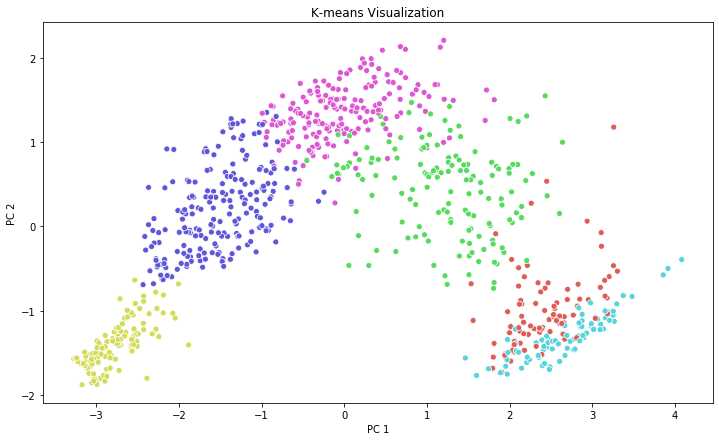

In [25]:
import seaborn as sns

# Plot k-means results with cluster assignments
plt.figure(figsize=(12,7))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", 6)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-means Visualization");

## Model Deployment

The last step in this notebook is to save out our K-means clustering model as well as our values that we used to standardize the numeric features. Then we save the cluster statistics to later use in a dashboard when reporting information about segments.

In [28]:
from dsx_ml.ml import save
import pprint

# Save k-means model out so it can be used for scoring
resp = save( model=kmeans_mdl, 
                 name='KMeans_model', 
                 x_test=df_prepped,  
                 algorithm_type='Classification' )
print("\n{} saved to:\n".format('KMeans_model'))
pprint.pprint(resp)

# Save out the mean and standard deviation of each numeric feature to score new data
with open('../datasets/col_means_stds.json', 'w') as f:
    json.dump(dict_standardise, f)


KMeans_model saved to:

{'path': '/user-home/1055/DSX_Projects/IndustryAccelerator-CustomerSegmentation/models/KMeans_model/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/scikit-learn-0.21/IndustryAccelerator-CustomerSegmentation/KMeans_model/1'}


In [29]:
# Save values for each numerical variable to be used for scoring and in the dashboard

prepped_data_pre_transform['CLUSTERS'] = kmeans_mdl.labels_
# increment cluster numbers by 1 so we start at 1 instead of 0
prepped_data_pre_transform['CLUSTERS'] = prepped_data_pre_transform['CLUSTERS'] + 1
summary_dict = {}

for cluster in range(1, prepped_data_pre_transform['CLUSTERS'].max()+1):
    summary_dict[cluster] = {}
    for col in numeric_cols:
        col_max = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS']==cluster][col].max()
        col_min = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS']==cluster][col].min()
        summary_dict[cluster][col] = {}
        summary_dict[cluster][col]['min'] = col_min
        summary_dict[cluster][col]['max'] = col_max

# save out data so that it can be used for scoring and dashboard
joblib.dump(summary_dict, '../datasets/numeric_data_ranges.joblib')

# save data for dynamic dashboard
prepped_data_pre_transform.to_csv('../datasets/cluster_df.csv')
prepped_data_pre_transform.head()

CUSTOMER_EMPLOYMENT_STATUS  CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES  \
0                   Employed                                  905.782674   
1               Selfemployed                                 4708.231946   
2                  Homemaker                                  847.381644   
3                  Homemaker                                 1502.860545   
4                   Employed                                  433.644930   

      CUSTOMER_PURSUIT CUSTOMER_CUSTOMER_BEHAVIOR CUSTOMER_GENDER  \
0  Capital Acquisition                   Moderate            Male   
1  Retirement Planning                 Aggressive          Female   
2   Increase Net Worth                     Growth          Female   
3   Increase Net Worth                     Growth          Female   
4      Estate Planning                   Moderate            Male   

  CUSTOMER_MARKET_GROUP CUSTOMER_AGE_RANGE  \
0          Accumulating           30 to 40   
1               Gifting        65 and over   
2          Accumulating           55 to 65   
3          Accumulating        65 and over   
4          Accumulating           40 to 55   

  CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY CUSTOMER_URBAN_CODE  \
0                             Recreation                City   
1                          Uncategorized               Urban   
2                          Transportaion               Urban   
3                          Transportaion               Urban   
4                                   Food                City   

  CUSTOMER_MARITAL_STATUS CUSTOMER_CREDIT_AUTHORITY_LEVEL  \
0                 Married                          Medium   
1                Divorced                       Very High   
2                 Married                        Very Low   
3                 Married                        Very Low   
4                 Married                          Medium   

  CUSTOMER_IMPORTANCE_LEVEL_CODE  CUSTOMER_ANNUAL_INCOME  \
0                   Low priority                 88936.0   
1                Normal priority                144189.0   
2                  High priority                127032.0   
3                  High priority                118908.0   
4                   Low priority                 83259.0   

  CUSTOMER_EDUCATION_LEVEL  CUSTOMER_SUMMARY_ASSETS  \
0                  College                 120823.0   
1             Professional                 253441.0   
2                      PhD                 203284.0   
3                      PhD                 194884.0   
4                  College                 123576.0   

   CUSTOMER_TENURE_IN_MONTHS  CLUSTERS  
0                          8         5  
1                         10         4  
2                         13         3  
3                          8         3  
4                          8         5

## Plot Variable Distribution by Cluster

The below code loops through each categorical variable and plots the distribution of each variable by cluster, followed by doing the same for numerical variables. 

Taking the example of Cluster 1, we see that the majority of customers are homemakers or retired. Their primary pursuit is increasing net worth and they exhibit aggressive customer behaviour. All of the customers in this cluster are female, 55 or over, and urban living. The annual income and assets of the customers in this cluster are on the higher end of all of our customers.

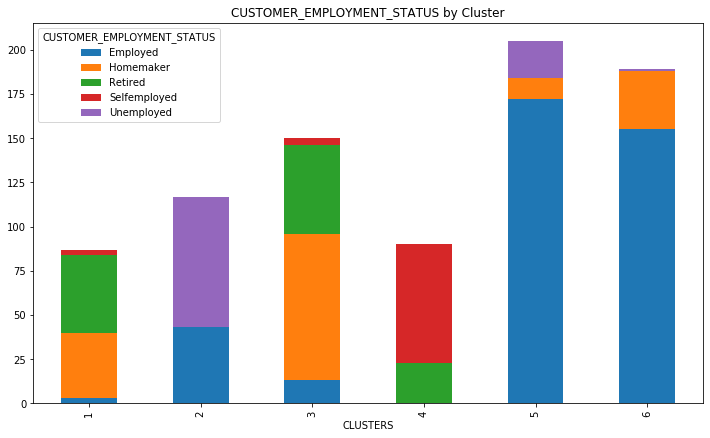

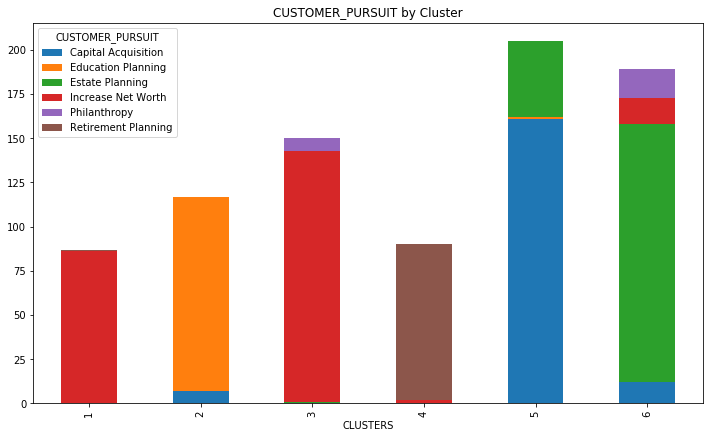

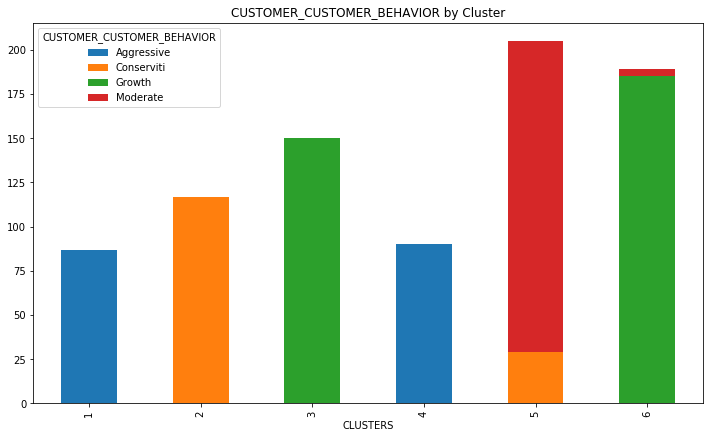

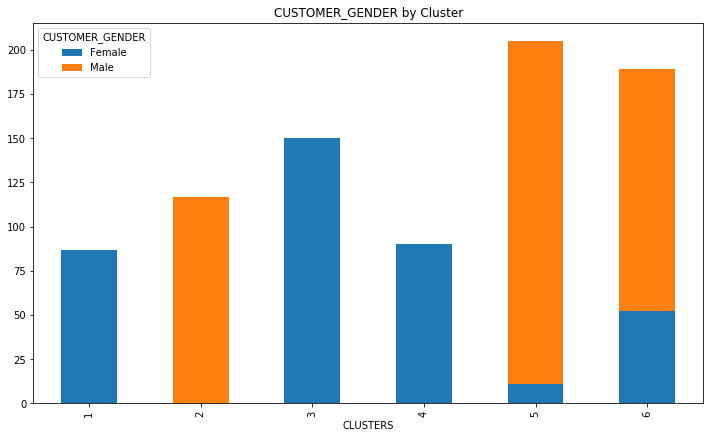

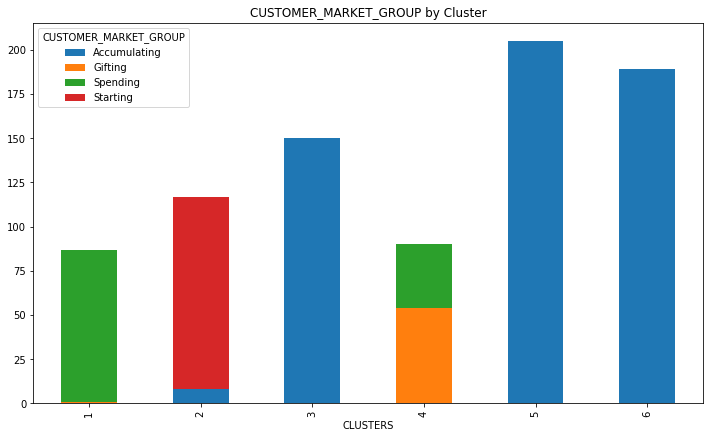

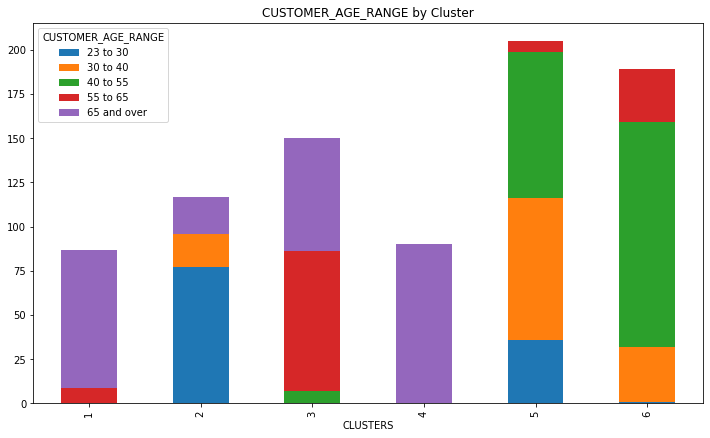

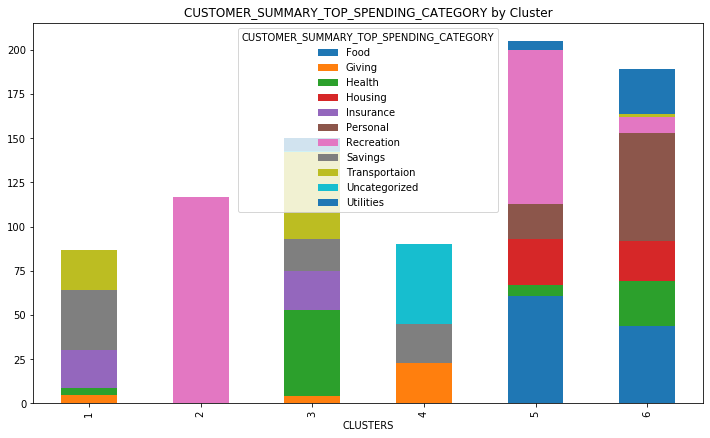

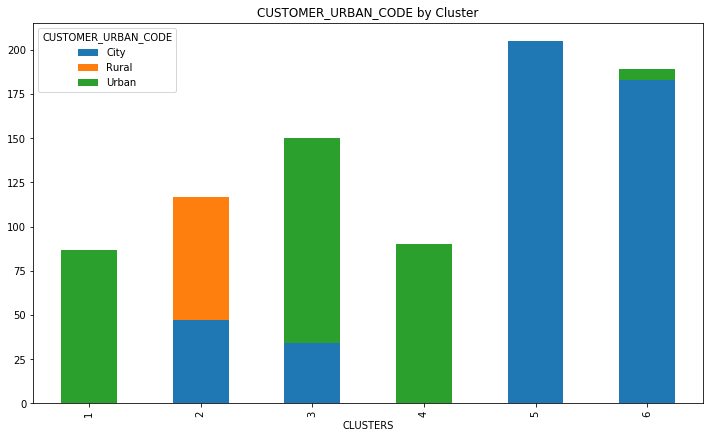

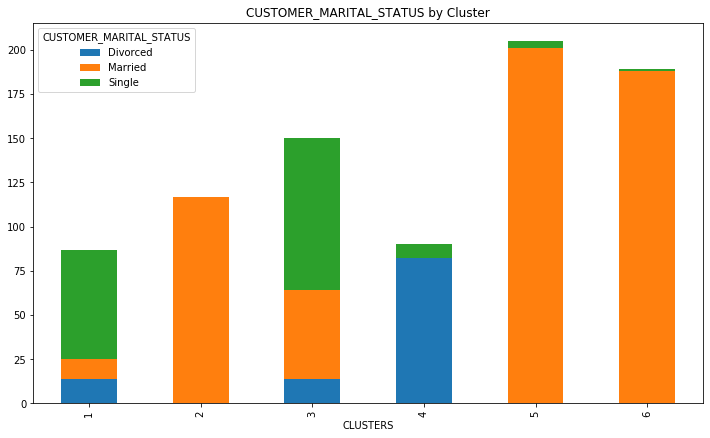

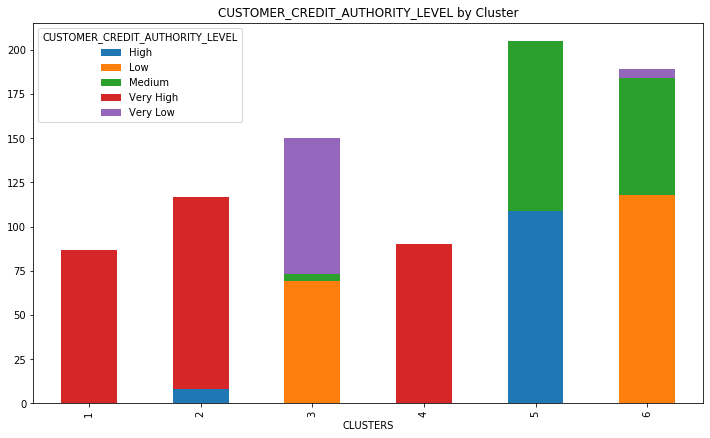

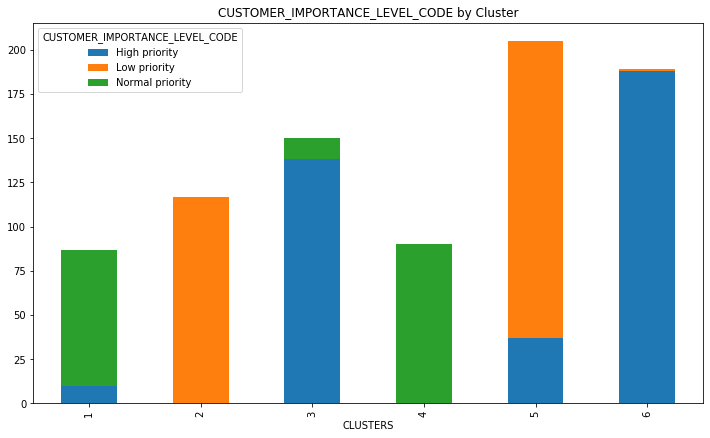

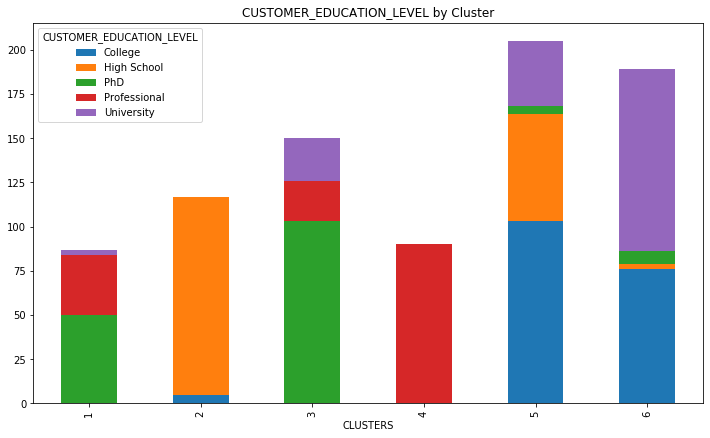

In [34]:
for var in categorical_cols:

    plot_categorical_vars(var, prepped_data_pre_transform)

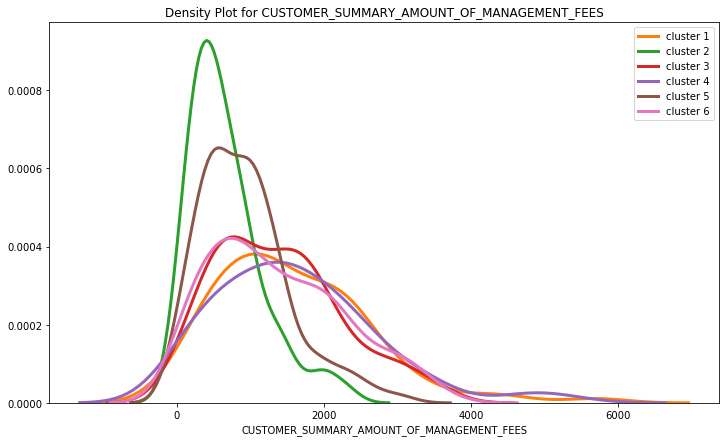

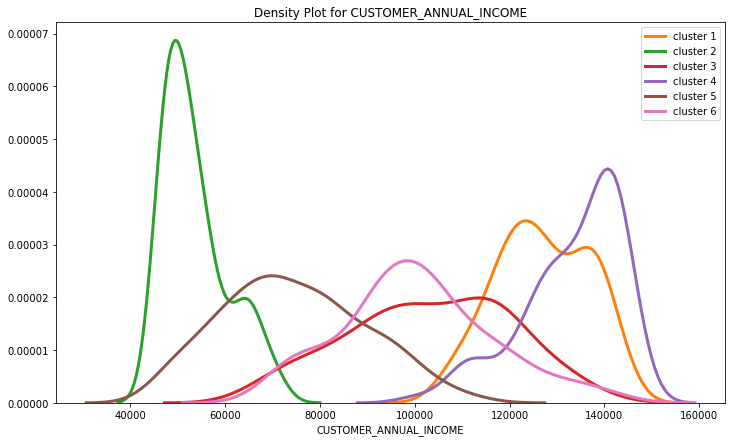

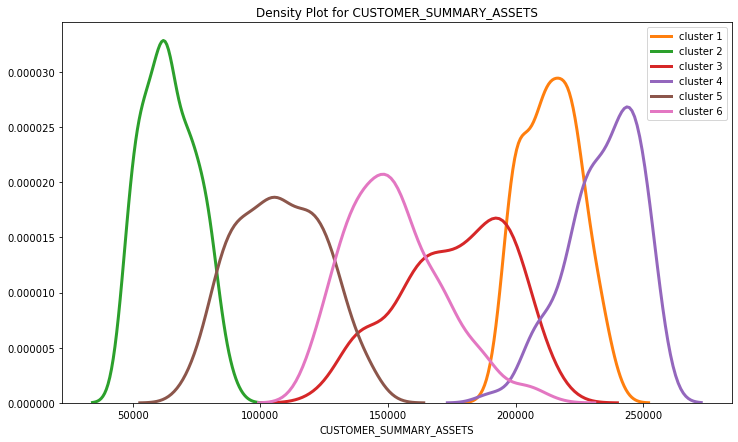

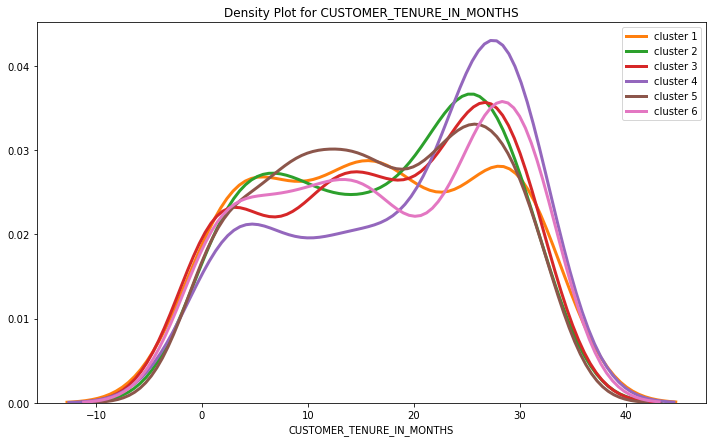

In [35]:
for col in numeric_cols:
    plot_numeric_vars(col, prepped_data_pre_transform)